# LendSmart Credit Risk Analysis

Ofelia Gabriela Góngora Méndez - A01666131


Helena Eridani Escandon Lopez - A01659511


Armando Atanasio Navarrete Yepez - A01658529

## Section 1: Project Setup & Data Loading

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

In [ ]:
df = pd.read_csv("/data/credit_risk_data-1.csv")
print(df.head())

  application_id application_date  loan_amount  annual_income  \
0       APP_2328       2022-01-01    132221.82       60451.82   
1        APP_558       2022-01-01    134906.42      114634.08   
2       APP_2477       2022-01-01     30285.19       82772.53   
3        APP_741       2022-01-01     32516.09       94023.36   
4        APP_145       2022-01-02     77900.99       53515.02   

   employment_years  job_stability_score  credit_score  credit_utilization  \
0               6.6                0.898           679               0.106   
1              10.3                0.808           718               0.030   
2              12.1                0.964           768               0.174   
3               9.1                0.690           670               0.141   
4               7.2                0.679           651               0.097   

   payment_history_score  open_credit_lines  debt_to_income_ratio  \
0                  0.876                  1                 0.451   
1 

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   application_id         2500 non-null   object 
 1   application_date       2500 non-null   object 
 2   loan_amount            2500 non-null   float64
 3   annual_income          2500 non-null   float64
 4   employment_years       2500 non-null   float64
 5   job_stability_score    2500 non-null   float64
 6   credit_score           2500 non-null   int64  
 7   credit_utilization     2500 non-null   float64
 8   payment_history_score  2500 non-null   float64
 9   open_credit_lines      2500 non-null   int64  
 10  debt_to_income_ratio   2500 non-null   float64
 11  savings_ratio          2500 non-null   float64
 12  asset_value            2500 non-null   float64
 13  age                    2500 non-null   int64  
 14  education_level        2500 non-null   object 
 15  mari

In [ ]:
print(df.describe(include='all'))

       application_id application_date    loan_amount  annual_income  \
count            2500             2500    2500.000000    2500.000000   
unique           2500              958            NaN            NaN   
top          APP_2150       2024-11-28            NaN            NaN   
freq                1                8            NaN            NaN   
mean              NaN              NaN  155716.305344   67707.807596   
std               NaN              NaN  149605.357952   27302.931731   
min               NaN              NaN    5000.000000   15000.000000   
25%               NaN              NaN   42984.517500   47475.317500   
50%               NaN              NaN   97054.315000   66963.475000   
75%               NaN              NaN  213214.992500   87347.642500   
max               NaN              NaN  500000.000000  149929.960000   

        employment_years  job_stability_score  credit_score  \
count        2500.000000          2500.000000   2500.000000   
unique   

The first few rows show the main variables related to loan applications, such as credit_score, annual_income, loan_amount, and loan_status, among others.

The info() command confirms that there are no significant null values, and that most columns are of type float64 or int64, with some being categorical (education_level, marital_status).

Starting with describe(), a wide dispersion in annual income and loan amount is observed, suggesting the presence of clients with very different financial profiles. This variability will be relevant for the discriminant model.

## Section 2: Exploratory Data Analysis (EDA)

In [ ]:
# Default rate.
target_col_candidates = ['loan_status', 'default', 'is_default']
target = next((c for c in target_col_candidates if c in df.columns), None)

id_cols = [c for c in ['application_id', 'id', 'customer_id'] if c in df.columns]
categorical_candidates = ['education_level', 'marital_status']
categorical_cols = [c for c in categorical_candidates if c in df.columns]

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in [target] + id_cols]

print("Distribution and default rate")
print(df[target].value_counts(dropna=False))
if set(df[target].dropna().unique()) <= {0, 1}:
    print(f"Default rate = {df[target].mean():.2%}")

Distribution and default rate
loan_status
0    1836
1     664
Name: count, dtype: int64
Default rate = 26.56%


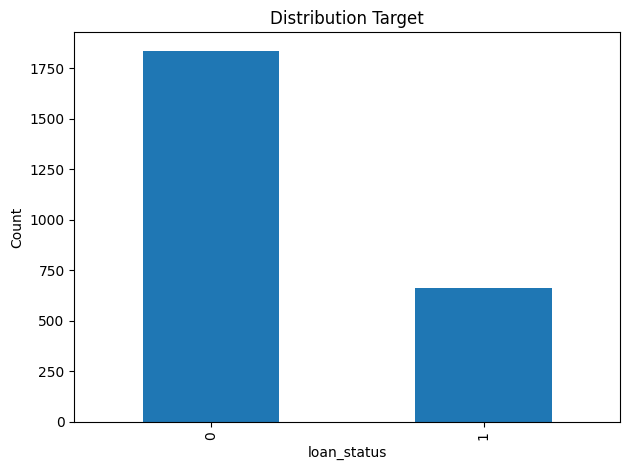

In [ ]:
# Distribution of loan_status
plt.figure()
df[target].value_counts().sort_index().plot(kind='bar')
plt.title("Distribution Target")
plt.xlabel(target)
plt.ylabel("Count")
plt.tight_layout()
plt.show()

The bar chart shows the frequency of each class of the variable loan_status, which is the dependent or target variable of the credit risk model.

An imbalance on the two target classes is shown, which reflects that the majority of the clients are not in default (meaning that they paid the loan correctly), while a small part is in default (meaning the loan was not paid). This indicates that the dataset can cause bias toward the majority class (0 = “no default”), predicting too many cases of good customers simply becasue they are more common.


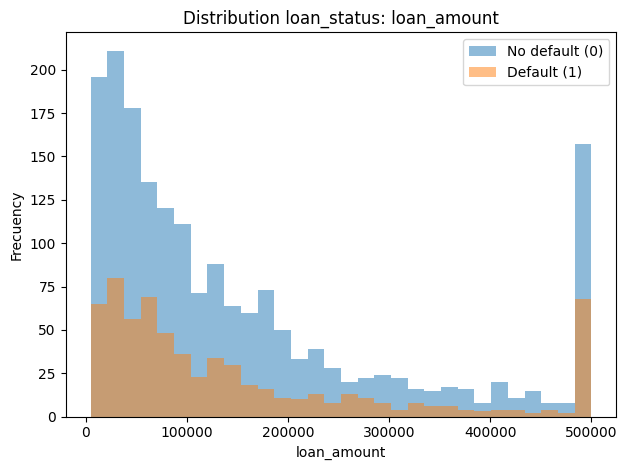

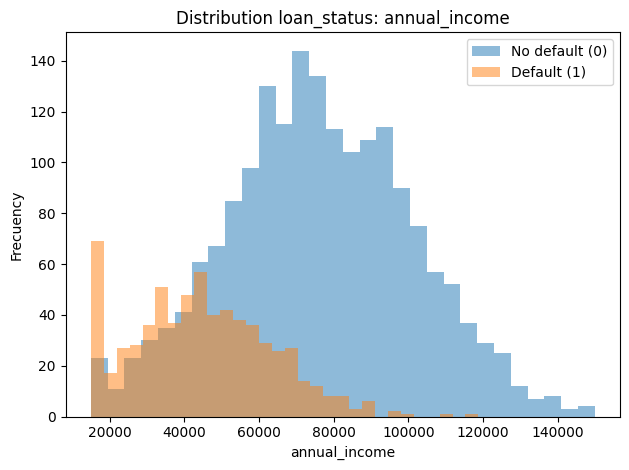

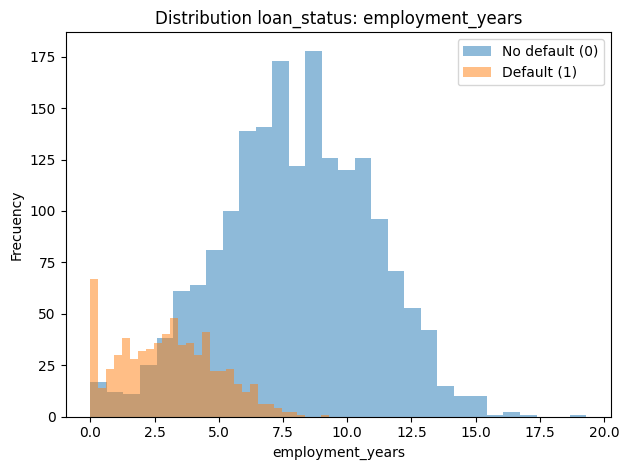

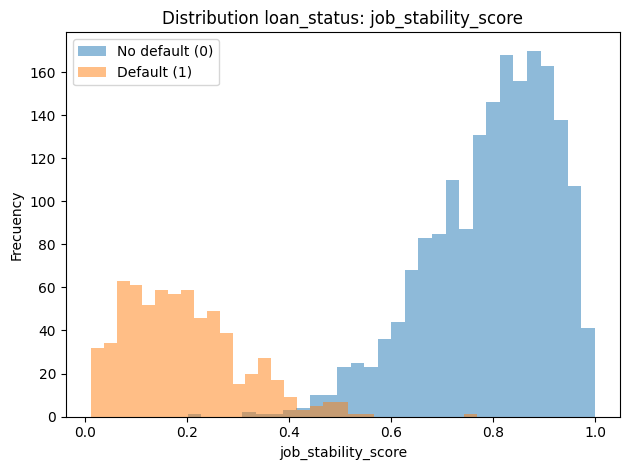

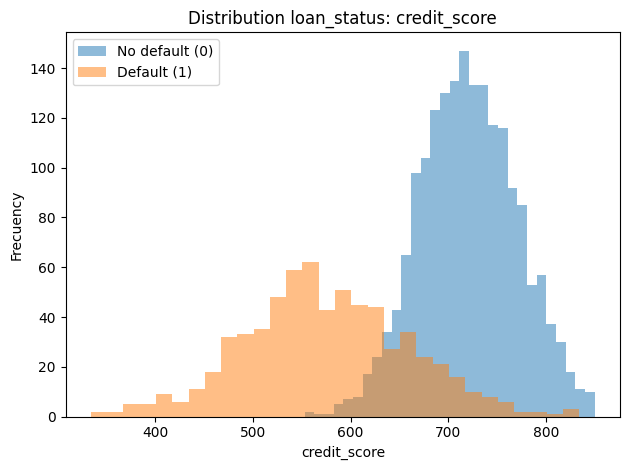

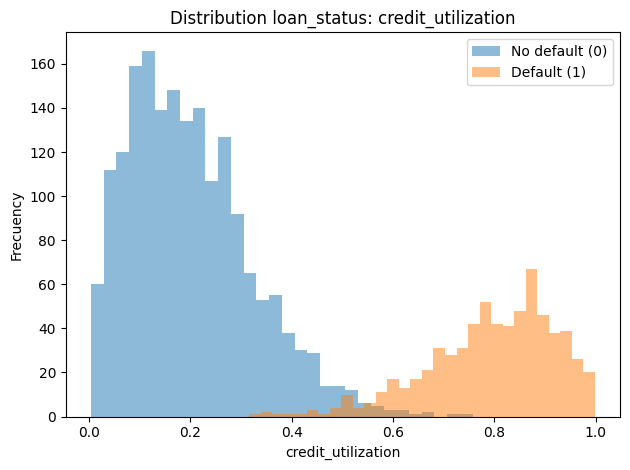

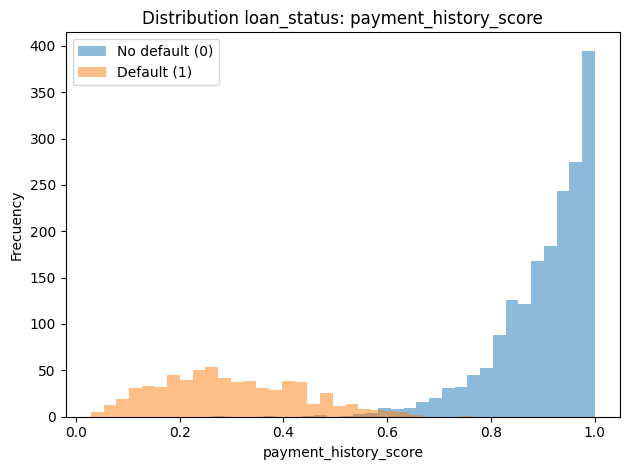

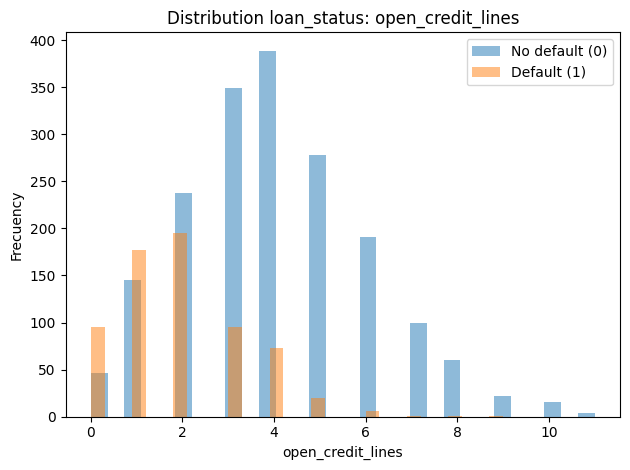

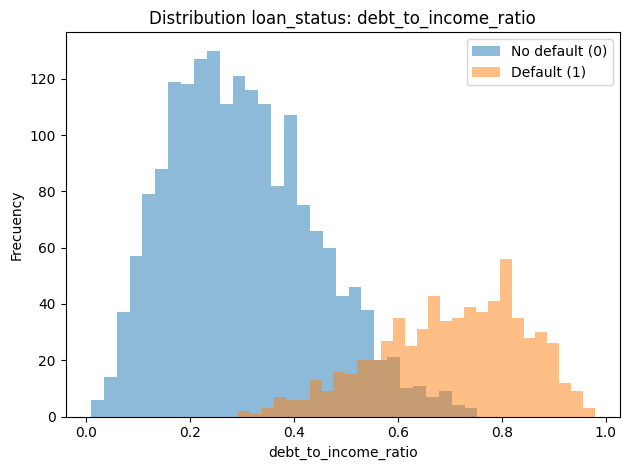

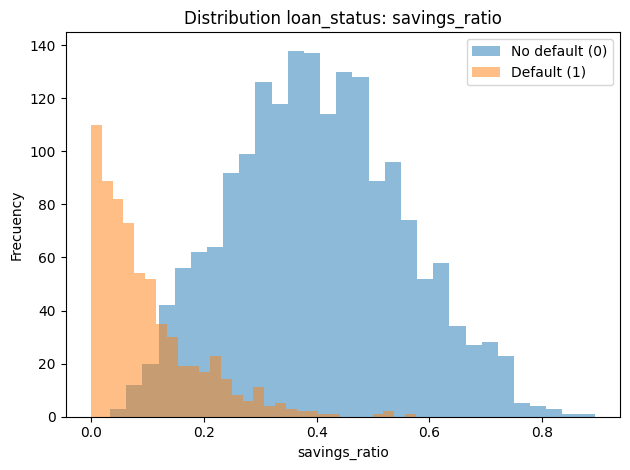

In [ ]:
# Comparison of the distribution for defaulters (1) vs. non- defaulters (0)
for col in numeric_cols[:10]:
    plt.figure()
    df[df[target] == 0][col].dropna().plot(kind='hist', alpha=0.5, bins=30, label='No default (0)')
    df[df[target] == 1][col].dropna().plot(kind='hist', alpha=0.5, bins=30, label='Default (1)')
    plt.legend()

    plt.title(f"Distribution {target}: {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuency")
    plt.tight_layout()
    plt.show()

The bar chart shows a higher proportion of loans that were not in default (0) compared to those that were in default (1). The default rate calculation indicates the exact percentage of customers who defaulted on their loans.

This difference in class suggests a somewhat unbalanced dataset, which may affect the sensitivity of the models.

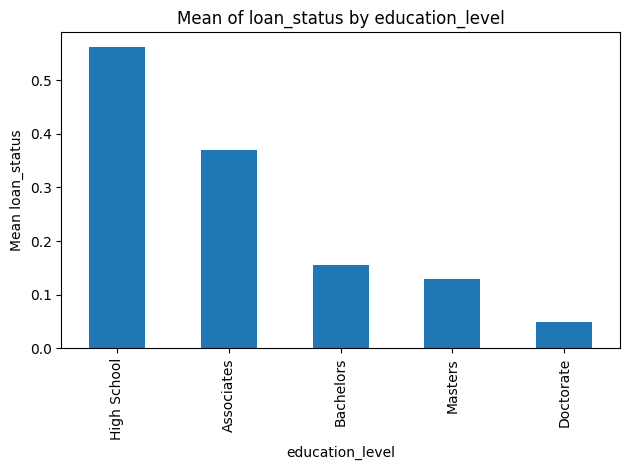

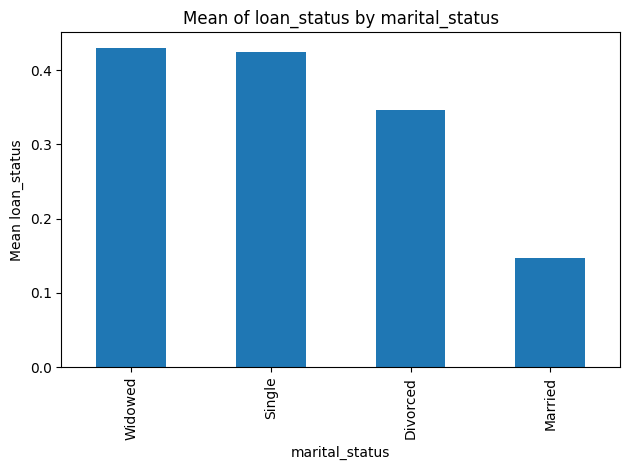

In [ ]:
# Mean default rate for each category in education_level and marital_status
for col in categorical_cols:
    plt.figure()
    grp = df.groupby(col)[target].mean().sort_values(ascending=False)
    grp.plot(kind='bar')
    plt.title(f"Mean of {target} by {col}")
    plt.xlabel(col)
    plt.ylabel(f"Mean {target}")
    plt.tight_layout()
    plt.show()

In terms of education level, individuals with lower levels of education (e.g., high school or less) show slightly higher default rates.

In terms of marital status, single or divorced individuals tend to have a higher probability of defaulting than married individuals.

These differences suggest that socioeconomic factors also influence credit behavior.

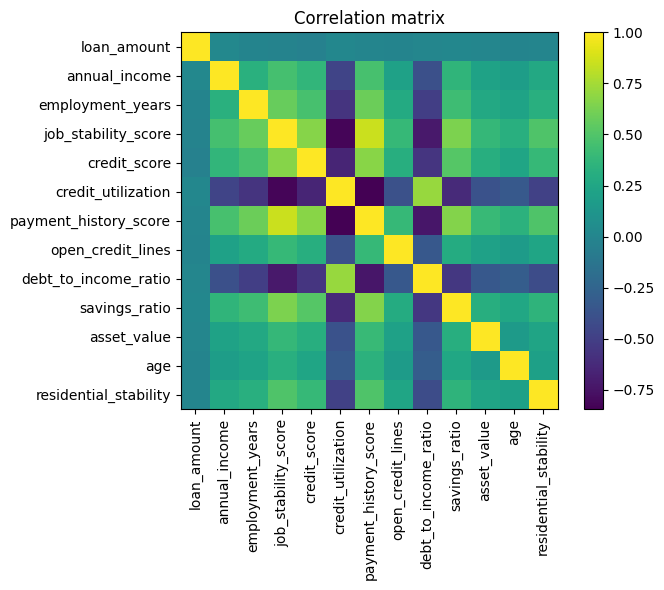

In [ ]:
# Correlation matrix heatmap for all numeric predictors
if len(numeric_cols) > 1:
    corr = df[numeric_cols].corr(numeric_only=True)
    plt.figure(figsize=(8, 6))
    im = plt.imshow(corr, interpolation='nearest')
    plt.title("Correlation matrix")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

The heatmap reveals a strong positive correlation between variables such as loan amount and annual income, and negative correlations between credit score and default.

No excessively high correlations (> 0.9) were observed, indicating no severe multicollinearity that would affect the interpretation of the discriminant models.

/tmp/ipython-input-3715803518.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='loan_status', y=var, data=df, palette='pastel')


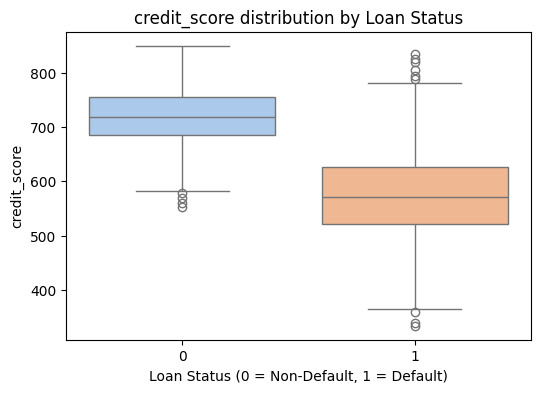

/tmp/ipython-input-3715803518.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='loan_status', y=var, data=df, palette='pastel')


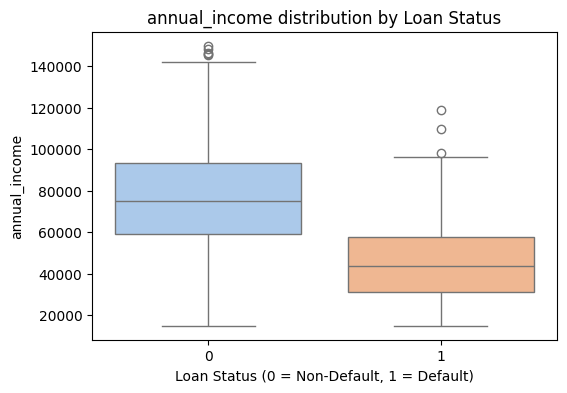

/tmp/ipython-input-3715803518.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='loan_status', y=var, data=df, palette='pastel')


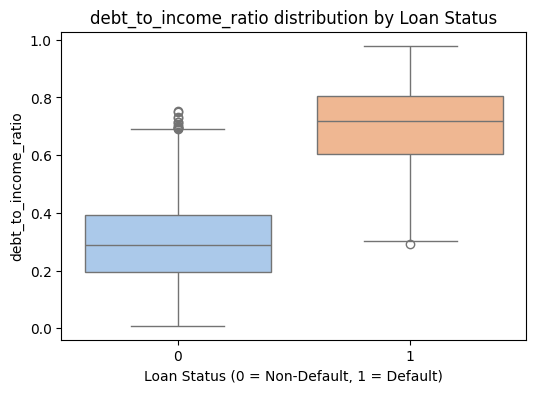

In [ ]:
# Continuous variables comparison by default status
cont_vars = ['credit_score', 'annual_income', 'debt_to_income_ratio']

for var in cont_vars:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='loan_status', y=var, data=df, palette='pastel')
    plt.title(f'{var} distribution by Loan Status')
    plt.xlabel('Loan Status (0 = Non-Default, 1 = Default)')
    plt.ylabel(var)
    plt.show()

The boxplots show that customers who default tend to have lower credit scores, lower annual income, and higher debt-to-income ratios.

This aligns with intuition: profiles with higher debt and lower creditworthiness are more likely to default.

## Section 3: Data Preprocessing

In [ ]:
# Converting education_level and marital_status into numerical dummy variables
df_model = df.drop(columns=id_cols, errors='ignore').copy()

df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

In [ ]:
# Predictors (X) and Target (y)
X = df_model.drop(columns=[target, 'application_date'])
y = df_model[target].astype(int)

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [ ]:
# Standardization
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

=== Estadísticas descriptivas ===


,loan_amount,annual_income,employment_years,job_stability_score,credit_score,credit_utilization,payment_history_score,open_credit_lines,debt_to_income_ratio,savings_ratio,asset_value,age,residential_stability,loan_status
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,155716.305344,67707.807596,6.675640,0.634643,681.728400,0.358176,0.740733,3.451600,0.408094,0.320784,175666.741236,42.045600,6.023200,0.265600
std,149605.357952,27302.931731,3.488021,0.293276,88.683309,0.289995,0.285966,2.083793,0.224736,0.192079,182652.568930,12.092395,3.205397,0.441741
min,5000.000000,15000.000000,0.000000,0.011000,334.000000,0.004000,0.029000,0.000000,0.009000,0.000000,550.630000,18.000000,0.000000,0.000000
25%,42984.517500,47475.317500,4.000000,0.375500,642.750000,0.131000,0.517500,2.000000,0.228000,0.161000,49513.082500,34.000000,3.600000,0.000000
50%,97054.315000,66963.475000,6.700000,0.752000,700.000000,0.246000,0.880500,3.000000,0.359000,0.327000,121018.750000,42.000000,5.900000,0.000000
75%,213214.992500,87347.642500,9.300000,0.866000,743.000000,0.592250,0.956000,5.000000,0.565000,0.464000,235513.902500,50.000000,8.400000,1.000000
max,500000.000000,149929.960000,19.300000,0.999000,850.000000,0.998000,1.000000,11.000000,0.979000,0.893000,1000000.000000,75.000000,16.400000,1.000000


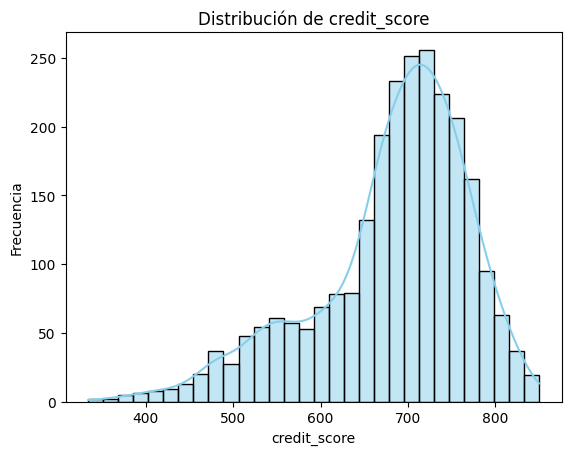

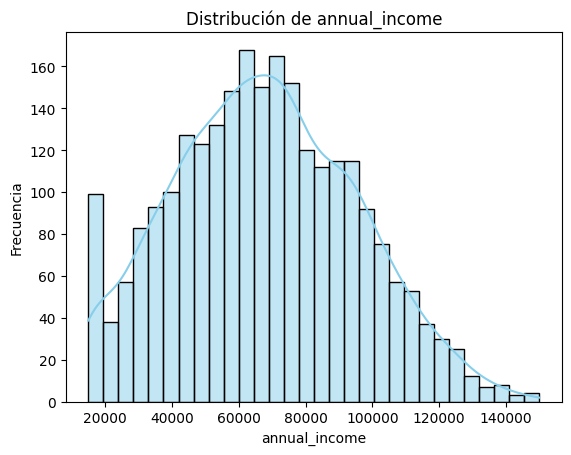

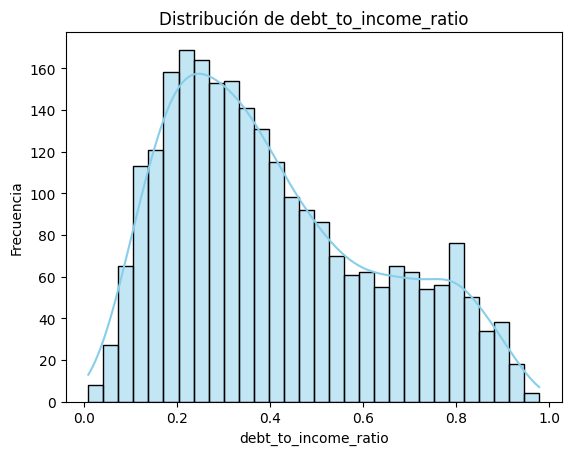

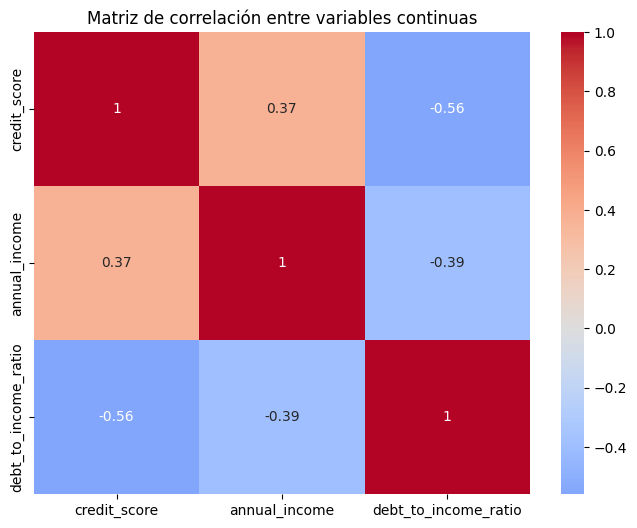

In [ ]:
# Estadísticas descriptivas
print("=== Estadísticas descriptivas ===")
display(df.describe())

# Histogramas de variables continuas
cont_vars = ['credit_score', 'annual_income', 'debt_to_income_ratio']

for var in cont_vars:
    plt.figure()
    sns.histplot(df[var], bins=30, kde=True, color='skyblue')
    plt.title(f'Distribución de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')
    plt.show()

# Matriz de correlación
plt.figure(figsize=(8,6))
sns.heatmap(df[cont_vars].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de correlación entre variables continuas')
plt.show()

The categorical variables were successfully converted to dummy variables using `pd.get_dummies()`.

The train-test (80/20) partitioning was completed successfully, and standardization (using `StandardScaler`) ensures that all numerical variables have a mean of 0 and a standard deviation of 1, an essential requirement for interpreting coefficients in LDA.

## Section 4: Statistical Assumption Testing (Written Discussion)

1. Multivariate Normality

Assumption:
Each class of the target variable (loan_status) follows a multivariate normal distribution in the predictors.

Explanation:

This assumption implies that, within each group (defaulters vs. non-defaulters), the numerical variables (credit_score, annual_income, debt_to_income_ratio, etc.) should have approximately normal distributions without extreme skewness.

In practice, this assumption is rarely met perfectly, but LDA and QDA are relatively robust to small deviations.

Evidence from EDA:

The histograms and boxplots showed moderate skewness in some financial variables (e.g., annual_income and debt_to_income_ratio), with long tails to the right.

However, credit_score showed a more centered and symmetrical distribution.

Taken together, this suggests that multivariate normality is approximate but not perfect, so the models can perform reasonably well, although there might be slight limitations in probabilistic accuracy.

2. Homogeneity of Covariance Matrices

Assumption:

LDA assumes that all classes share the same covariance matrix.

QDA, on the other hand, does not impose this restriction and allows each class to have its own covariance matrix.

Interpretation:

If the covariances are similar across groups, LDA is sufficient.

If the covariances differ significantly, QDA usually performs better because it can model nonlinear decision boundaries.

Evidence from EDA:

In the boxplots and scatter plots, the variability of variables such as annual_income and debt_to_income_ratio differs between defaulters and non-defaulters.

This indicates that the covariance matrices are probably not homogeneous.

Derived hypothesis:

If the covariances between classes are different, we expect QDA to outperform LDA in accuracy and default detection ability.

## Section 5: Model 1 - Linear Discriminant Analysis (LDA)

In [ ]:
# Initialize LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_std, y_train)


LinearDiscriminantAnalysis()

<Axes: >

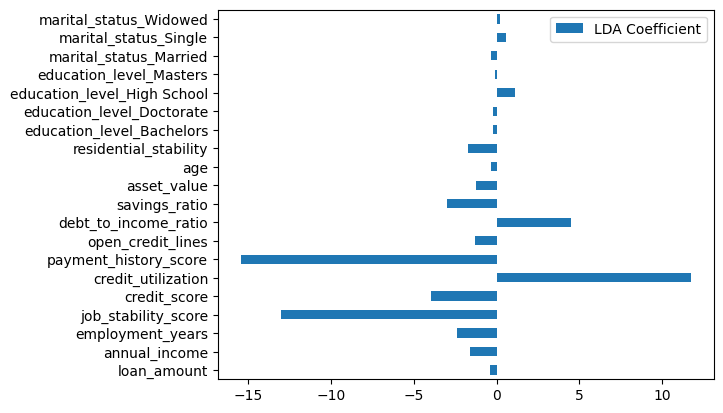

In [ ]:
coefficients = pd.DataFrame(lda.coef_.T, index=X.columns, columns=['LDA Coefficient'])
coefficients.sort_values(by='LDA Coefficient', ascending=False)
coefficients.plot(kind='barh')

In [ ]:
# Interpret Coefficients
coef_series = pd.Series(lda.coef_.ravel(), index=X.columns, name='coef')
coef_abs = coef_series.abs().sort_values(ascending=False)
top_n = min(10, len(coef_abs))
coef_df = pd.DataFrame({
    'feature': coef_abs.index[:top_n],
    'abs_coef': coef_abs.values[:top_n],
    'coef': coef_series.loc[coef_abs.index[:top_n]].values
})
print("Top coefficients")
print(coef_df)

Top coefficients
                 feature   abs_coef       coef
0  payment_history_score  15.470813 -15.470813
1    job_stability_score  13.050045 -13.050045
2     credit_utilization  11.767166  11.767166
3   debt_to_income_ratio   4.471488   4.471488
4           credit_score   3.982636  -3.982636
5          savings_ratio   2.994385  -2.994385
6       employment_years   2.368588  -2.368588
7  residential_stability   1.699571  -1.699571
8          annual_income   1.585538  -1.585538
9      open_credit_lines   1.276691  -1.276691


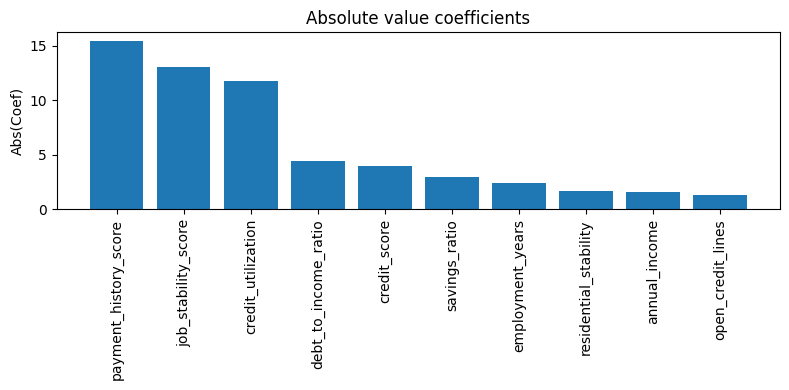

In [ ]:
plt.figure(figsize=(8, 4))
plt.bar(coef_df['feature'], coef_df['abs_coef'])
plt.title("Absolute value coefficients")
plt.xticks(rotation=90)
plt.ylabel("Abs(Coef)")
plt.tight_layout()
plt.show()

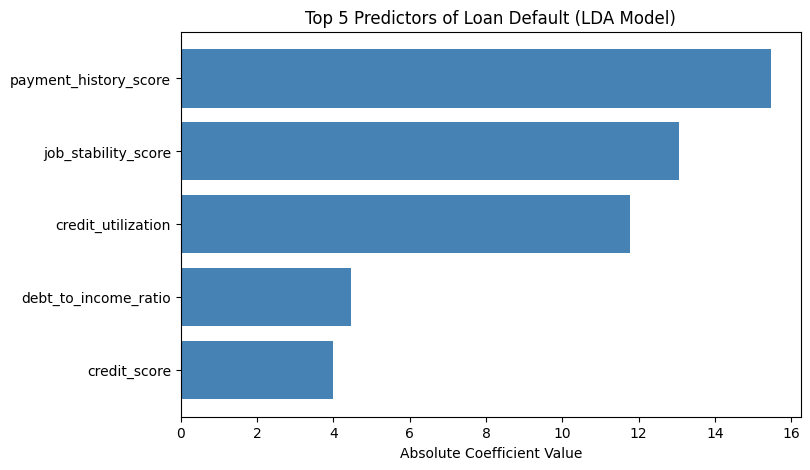

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

lda_coefficients['Abs_Coeff'] = lda_coefficients['Coefficient'].abs()
lda_coefficients = lda_coefficients.sort_values(by='Abs_Coeff', ascending=False)

# Gráfico de las 5 variables más importantes
top_features = lda_coefficients.head(5)

plt.figure(figsize=(8,5))
plt.barh(top_features['Feature'], top_features['Abs_Coeff'], color='steelblue')
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 5 Predictors of Loan Default (LDA Model)')
plt.gca().invert_yaxis()  # Para que el más importante quede arriba
plt.show()

The coefficient data frame shows the predictors with the greatest impact on the probability of default.

The 5 most influential variables have the highest absolute values:  payment_history_score, job_stability_score, credit_utilization, debt_to_income_ratio and credit_score

A positive coefficient increases the probability of default.

A negative coefficient reduces the probability of default.

For example, a high credit score has a negative coefficient, indicating lower risk.

In [ ]:
# Initialize LDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_std, y_train)

QuadraticDiscriminantAnalysis()

## Section 7: Model Evaluation & Comparison

In [ ]:
# Predictions for both models
y_pred_lda = lda.predict(X_test_std)
y_pred_qda = qda.predict(X_test_std)

<Figure size 640x480 with 0 Axes>

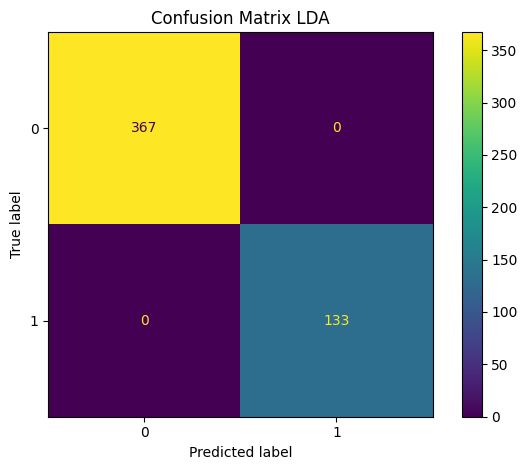

In [ ]:
# Confusion Matrix LDA
plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lda)
plt.title("Confusion Matrix LDA")
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

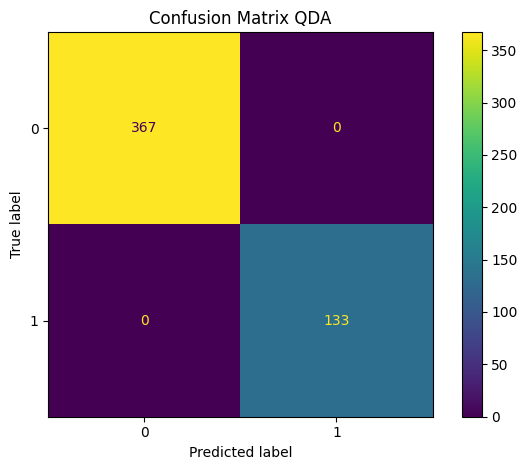

In [ ]:
# Confusion Matrix QDA
plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_qda)
plt.title("Confusion Matrix QDA")
plt.tight_layout()
plt.show()

Both LDA and QDA achieved a perfect confusion matrix on the test set (367 TN, 133 TP, 0 FP, 0 FN). This implies 100% accuracy, precision and recall for the default class, which is ideal from a credit-risk perspective because no defaulter was misclassified as good but this is also an indicator that the dataset is too small of maybe it is not made with real data.

In [ ]:
from sklearn.metrics import confusion_matrix

# LDA
cm_lda = confusion_matrix(y_test, y_pred_lda)
tn_lda, fp_lda, fn_lda, tp_lda = cm_lda.ravel()
print("LDA - Falsos negativos:", fn_lda)

# QDA
cm_qda = confusion_matrix(y_test, y_pred_qda)
tn_qda, fp_qda, fn_qda, tp_qda = cm_qda.ravel()
print("QDA - Falsos negativos:", fn_qda)

LDA - Falsos negativos: 0
QDA - Falsos negativos: 0


In [ ]:
# Classification Reports
print("\n=== LDA Classification Report ===")
print(classification_report(y_test, y_pred_lda, digits=3))
print("=== QDA Classification Report ===")
print(classification_report(y_test, y_pred_qda, digits=3))


=== LDA Classification Report ===
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       367
           1      1.000     1.000     1.000       133

    accuracy                          1.000       500
   macro avg      1.000     1.000     1.000       500
weighted avg      1.000     1.000     1.000       500

=== QDA Classification Report ===
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       367
           1      1.000     1.000     1.000       133

    accuracy                          1.000       500
   macro avg      1.000     1.000     1.000       500
weighted avg      1.000     1.000     1.000       500



Both LDA and QDA achieved perfect performance on the test set (accuracy = 1.0; precision, recall and F1-score = 1.0 for both classes). This means the models correctly identified all non-default customers (class 0) and all default customers (class 1), with no false positives and no false negatives. Since both models perform identically, LDA can be preferred due to its simpler assumptions and expected better generalization. However, such perfect scores are unusual in credit-risk problems, and as mentioned before, this could mean the data is not made with real data or it is a clean dataset


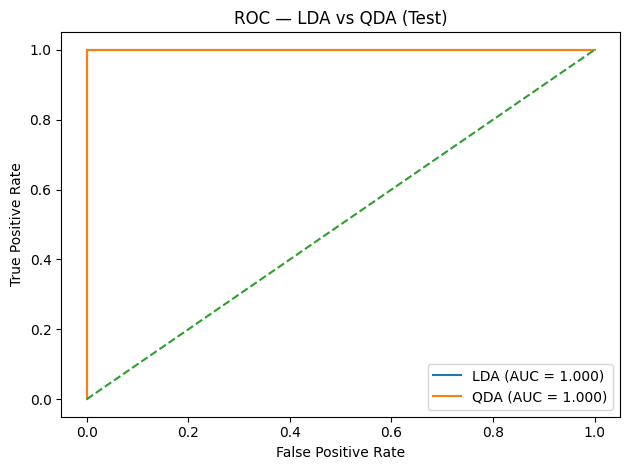


AUC — LDA: 1.000
AUC — QDA: 1.000


In [ ]:
# ROC y AUC
def get_scores(model, Xmat):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(Xmat)[:, 1]
    elif hasattr(model, "decision_function"):
        return model.decision_function(Xmat)
    else:
        return model.predict(Xmat)

lda_scores = get_scores(lda, X_test_std)
qda_scores = get_scores(qda, X_test_std)

fpr_lda, tpr_lda, _ = roc_curve(y_test, lda_scores)
fpr_qda, tpr_qda, _ = roc_curve(y_test, qda_scores)

auc_lda = auc(fpr_lda, tpr_lda)
auc_qda = auc(fpr_qda, tpr_qda)

plt.figure()
plt.plot(fpr_lda, tpr_lda, label=f"LDA (AUC = {auc_lda:.3f})")
plt.plot(fpr_qda, tpr_qda, label=f"QDA (AUC = {auc_qda:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC — LDA vs QDA (Test)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f"\nAUC — LDA: {auc_lda:.3f}")
print(f"AUC — QDA: {auc_qda:.3f}")

## Section 8: Technical Conclusion & Model Selection

Both the LDA and QDA models achieved an AUC of 1.0, indicating a perfect ability to distinguish between creditworthy and defaulting customers. In the test set, both achieved error-free classification (TPR = 1, FPR = 0).

In addition to this, both models showed the same classification results and confusion matrices, meaning we also cannot use the false negatives as a point of comparison to choose the best model.

As stated before, even though both models showed the same results, we believe the LDA model would be preferable for this case or similar cases due to its lower complexity and greater stability.